In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### iterate through the folders to create a dataframe of the form filepaths labels

In [20]:
sdir=r'/Users/nirwanaamir/Downloads/datasetskripsi'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths              labels
0  /Users/nirwanaamir/Downloads/datasetskripsi/Ay...  Ayam Woku (Manado)
1  /Users/nirwanaamir/Downloads/datasetskripsi/Ay...  Ayam Woku (Manado)
2  /Users/nirwanaamir/Downloads/datasetskripsi/Ay...  Ayam Woku (Manado)
3  /Users/nirwanaamir/Downloads/datasetskripsi/Ay...  Ayam Woku (Manado)
4  /Users/nirwanaamir/Downloads/datasetskripsi/Ay...  Ayam Woku (Manado)
labels
Ayam Woku (Manado)             50
Mie Titi(Makassar)             50
Deppa Tori_ (Toraja)           50
Konro (Makassar)               50
Coto Makassar (Makassar)       50
Pisang Ijo (Makassar)          50
Kasuami (Wakatobi)             50
Kue Tetu(Sulawesi Barat)       50
Cakalang Pampis (Manado)       50
Bubur Manado (Manado)          50
Lawa Bale (Palopo)             50
Panada (Sulawesi  Utara)       50
Kapurung (Palopo)              50
Barongko (Sulawesi Selatan)    50
Nasu Palekko (Pinrang)         50
Lalampa(Sulawesi Tengah)       50
Pa_piong (T

### split df into train_df, test_df and valid_df

In [21]:
train_split=.7
test_split=.2
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  700   test_df length:  200   valid_df length:  100


### create train, test, valid  generators

In [22]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
# Filter out rows with invalid image filenames
train_df = train_df[train_df['filepaths'].apply(lambda x: os.path.exists(x))]
valid_df = valid_df[valid_df['filepaths'].apply(lambda x: os.path.exists(x))]
test_df = test_df[test_df['filepaths'].apply(lambda x: os.path.exists(x))]

# Flow from DataFrame with resizing and augmentation
train_generator = train_gen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_generator = valid_gen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size
)

# Get the class indices from the generators
train_classes = list(train_generator.class_indices.keys())
valid_classes = list(valid_generator.class_indices.keys())
test_classes = list(test_generator.class_indices.keys())

print("Train Classes:", train_classes)
print("Valid Classes:", valid_classes)
print("Test Classes:", test_classes)




test batch size:  50   test steps:  4
Found 695 validated image filenames belonging to 20 classes.
Found 100 validated image filenames belonging to 20 classes.
Found 198 validated image filenames belonging to 20 classes.
Train Classes: ['Ayam Woku (Manado)', 'Barongko (Sulawesi Selatan)', 'Bubur Manado (Manado)', 'Cakalang Pampis (Manado)', 'Coto Makassar (Makassar)', 'Deppa Tori_ (Toraja)', 'Jagung Marning (Bulukumba)', 'Kapurung (Palopo)', 'Kasuami (Wakatobi)', 'Konro (Makassar)', 'Kue Tetu(Sulawesi Barat)', 'Lalampa(Sulawesi Tengah)', 'Lapa-Lapa (Buton)', 'Lawa Bale (Palopo)', 'Mie Titi(Makassar)', 'Nasu Palekko (Pinrang)', 'Pa_piong (Toraja)', 'Panada (Sulawesi  Utara)', 'Pisang Ijo (Makassar)', 'klappertaart (Manado)']
Valid Classes: ['Ayam Woku (Manado)', 'Barongko (Sulawesi Selatan)', 'Bubur Manado (Manado)', 'Cakalang Pampis (Manado)', 'Coto Makassar (Makassar)', 'Deppa Tori_ (Toraja)', 'Jagung Marning (Bulukumba)', 'Kapurung (Palopo)', 'Kasuami (Wakatobi)', 'Konro (Makassar)',

/Users/nirwanaamir/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/Users/nirwanaamir/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


### create function to show some image examples

In [23]:
def show_image_samples(gen):
    class_dict = gen.class_indices
    classes = list(class_dict.keys())    
    images, labels = next(gen)  # mengambil satu batch contoh gambar dari generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:   # menampilkan maksimal 25 gambar
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()





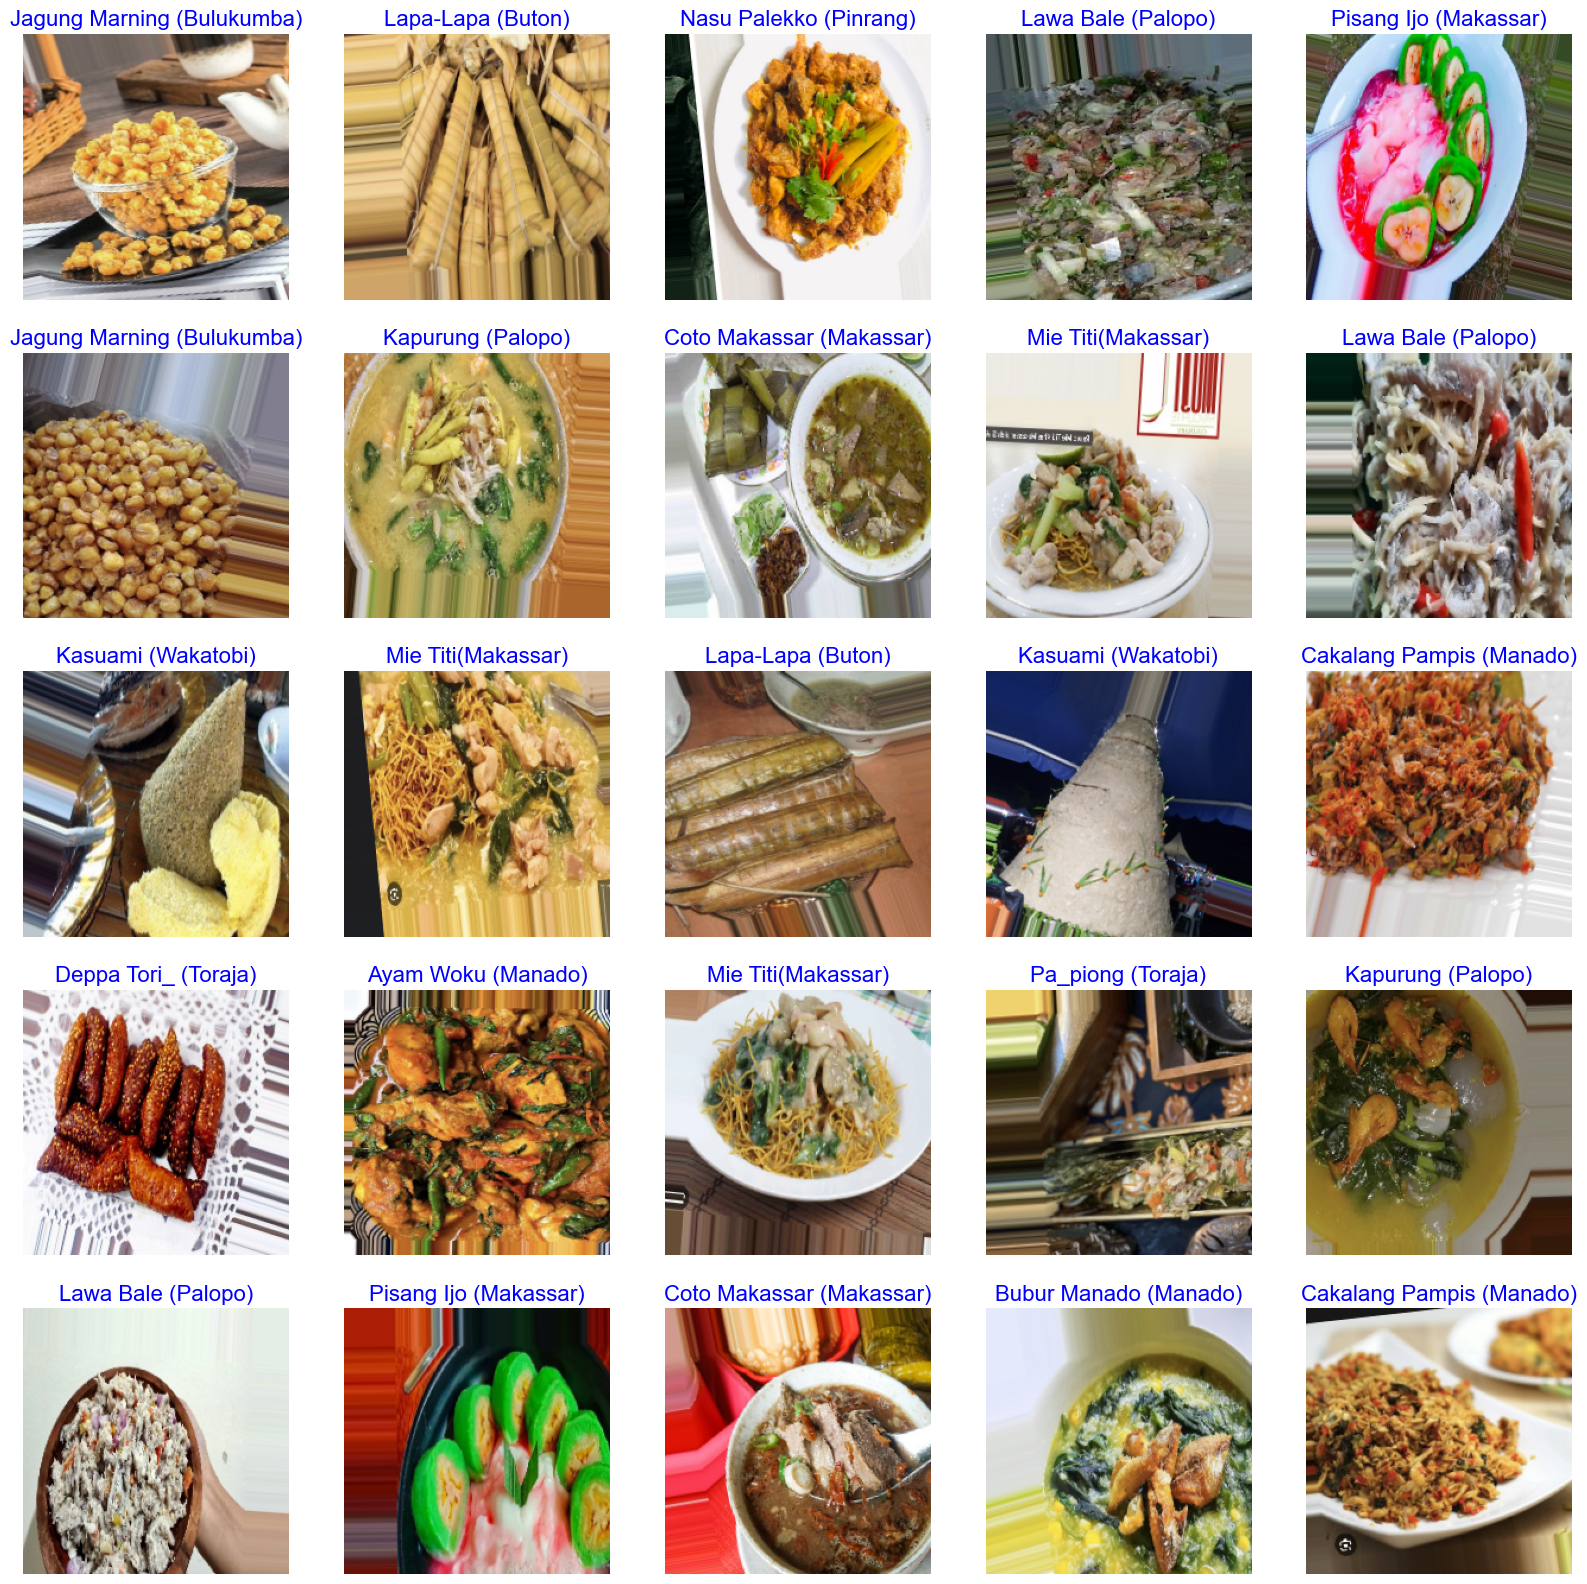

In [24]:
show_image_samples(train_generator)

### create the model

In [25]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [26]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [27]:
base_model.trainable = False

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(20, activation='softmax'))  # num_classes is the number of classes in your classification task

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [30]:


epochs=10

history=model.fit(x=train_generator, epochs=epochs, validation_data=valid_generator)    


Epoch 1/10
11/11 [==============================] - 23s 2s/step - loss: 7.1533 - accuracy: 0.0417 - val_loss: 2.9919 - val_accuracy: 0.0400
Epoch 2/10
11/11 [==============================] - 21s 2s/step - loss: 2.9882 - accuracy: 0.0504 - val_loss: 2.9471 - val_accuracy: 0.0500
Epoch 3/10
11/11 [==============================] - 21s 2s/step - loss: 2.9329 - accuracy: 0.0705 - val_loss: 2.8709 - val_accuracy: 0.1800
Epoch 4/10
11/11 [==============================] - 22s 2s/step - loss: 2.8932 - accuracy: 0.1007 - val_loss: 2.8322 - val_accuracy: 0.1300
Epoch 5/10
11/11 [==============================] - 22s 2s/step - loss: 2.8462 - accuracy: 0.0935 - val_loss: 2.7980 - val_accuracy: 0.1300
Epoch 6/10
11/11 [==============================] - 23s 2s/step - loss: 2.7797 - accuracy: 0.1266 - val_loss: 2.7771 - val_accuracy: 0.1500
Epoch 7/10
11/11 [==============================] - 21s 2s/step - loss: 2.7394 - accuracy: 0.1324 - val_loss: 2.6754 - val_accuracy: 0.1500
Epoch 8/10
11/11 [==

### define function to print text in RGB foreground and background colors

In [31]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### define function to plot the training data

In [32]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [33]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

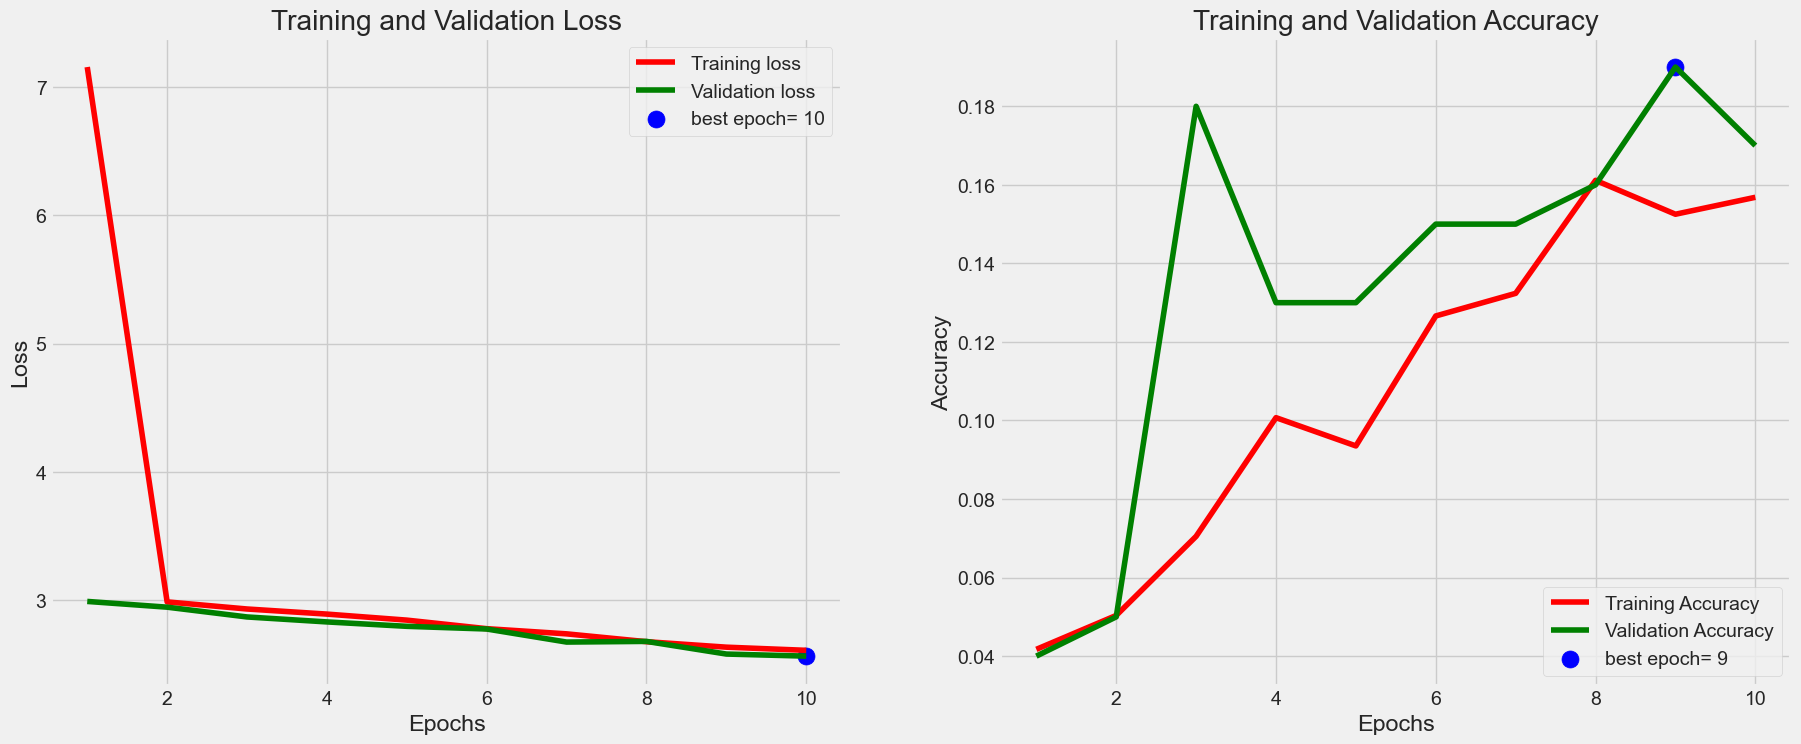

ValueError: Failed to find data adapter that can handle input: <class 'keras.src.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>

In [34]:
tr_plot(history,0)
save_dir=r'./'
subject='Batik Exception'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

4/4 [==============================] - 10s 2s/step


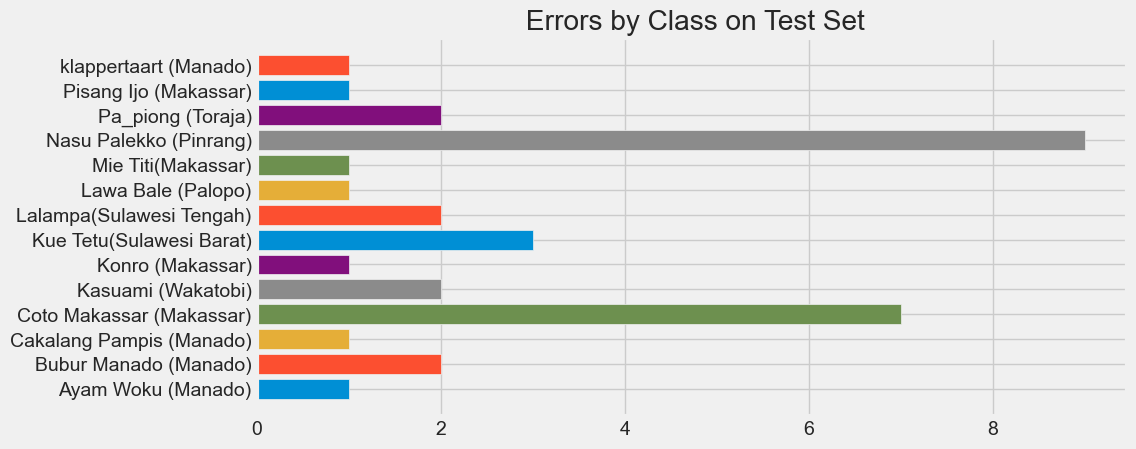

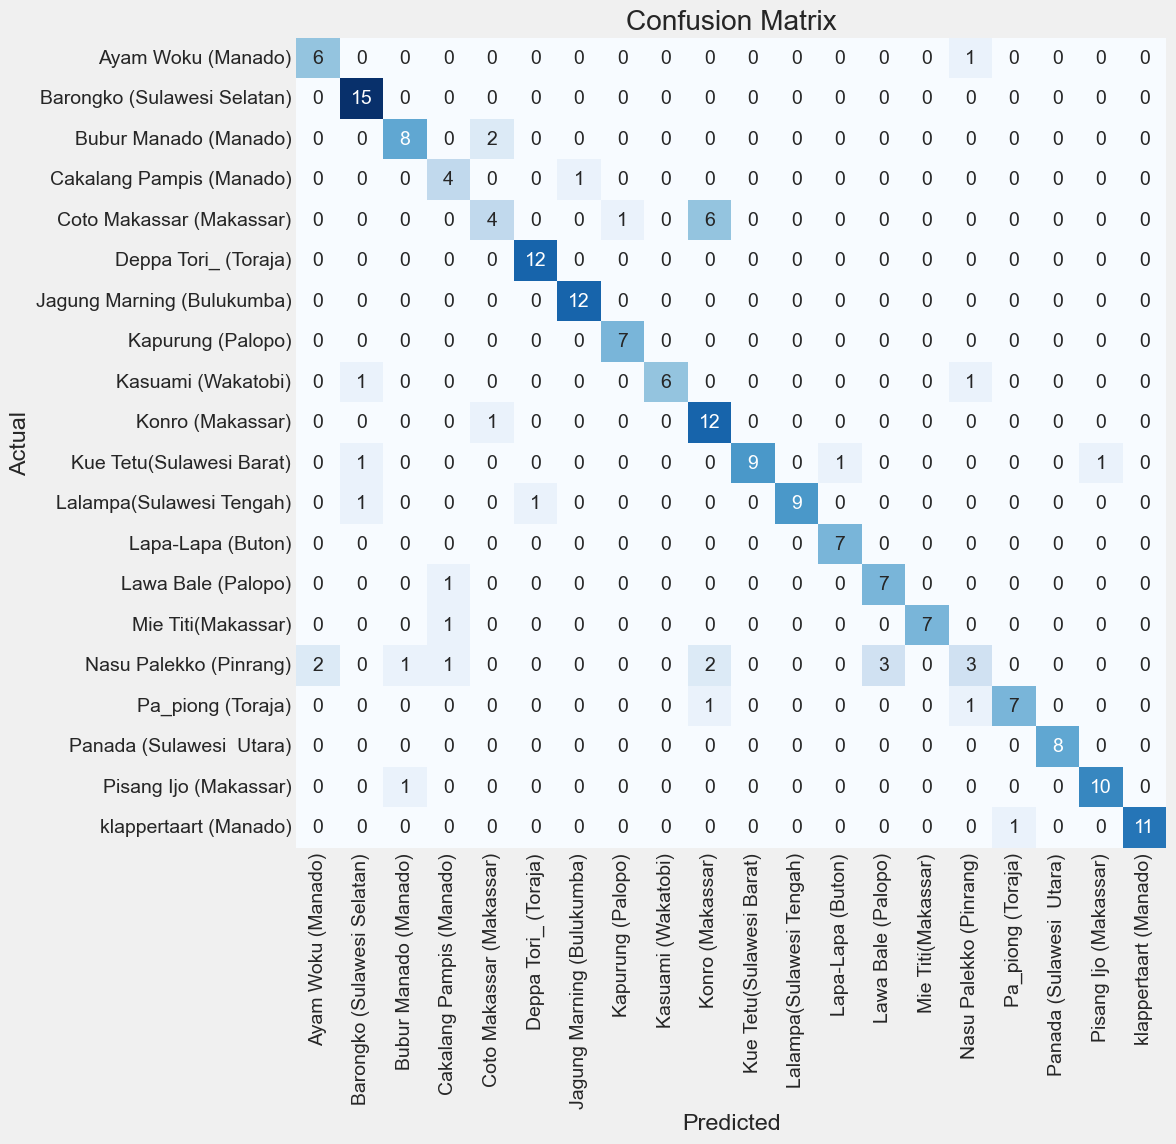

Classification Report:
----------------------
                              precision    recall  f1-score   support

         Ayam Woku (Manado)       0.75      0.86      0.80         7
Barongko (Sulawesi Selatan)       0.83      1.00      0.91        15
      Bubur Manado (Manado)       0.80      0.80      0.80        10
   Cakalang Pampis (Manado)       0.57      0.80      0.67         5
   Coto Makassar (Makassar)       0.57      0.36      0.44        11
       Deppa Tori_ (Toraja)       0.92      1.00      0.96        12
 Jagung Marning (Bulukumba)       0.92      1.00      0.96        12
          Kapurung (Palopo)       0.88      1.00      0.93         7
         Kasuami (Wakatobi)       1.00      0.75      0.86         8
           Konro (Makassar)       0.57      0.92      0.71        13
   Kue Tetu(Sulawesi Barat)       1.00      0.75      0.86        12
   Lalampa(Sulawesi Tengah)       1.00      0.82      0.90        11
          Lapa-Lapa (Buton)       0.88      1.00      0

In [ ]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  